<a href="https://colab.research.google.com/github/drizedunn/Food-Preference/blob/main/food_preference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Preference
In this project, we predict the food type of individuals. It can either be western food or tradition food.

In [19]:
# Importing the needed libraries

# !pip install shap
# !pip install colorama

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from colorama import Style, Fore, Back
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from joblib import dump

from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score

import shap
import warnings

plt.style.use('seaborn')
warnings.filterwarnings('ignore')
%matplotlib inline

##Data Collection and loading

The data is a food survey conducted among participants from different countries and demography which can be found [here](https://www.kaggle.com/datasets/vijayashreer/food-preferences)

In [2]:
# reading the data
data = pd.read_csv('/content/drive/MyDrive/Datasets/Food_Preference.csv')
#data = pd.read_csv('./dataset/Food_Preference.csv')

In [ ]:
#Displaying the first five rows of the data
data.head()

,Timestamp,Participant_ID,Gender,Nationality,Age,Food,Juice,Dessert
0,2019/05/07 2:59:13 PM GMT+8,FPS001,Male,Indian,24,Traditional food,Fresh Juice,Maybe
1,2019/05/07 2:59:45 PM GMT+8,FPS002,Female,Indian,22,Western Food,Carbonated drinks,Yes
2,2019/05/07 3:00:05 PM GMT+8,FPS003,Male,Indian,31,Western Food,Fresh Juice,Maybe
3,2019/05/07 3:00:11 PM GMT+8,FPS004,Female,Indian,25,Traditional food,Fresh Juice,Maybe
4,2019/05/07 3:02:50 PM GMT+8,FPS005,Male,Indian,27,Traditional food,Fresh Juice,Maybe


In [ ]:
#Displaying the last five rows of the data
data.tail()

,Timestamp,Participant_ID,Gender,Nationality,Age,Food,Juice,Dessert
283,2019/05/10 9:24:00 AM GMT+8,FPS284,Male,Indian,27,Western Food,Fresh Juice,Yes
284,2019/05/10 9:32:54 AM GMT+8,FPS285,Male,Indian,24,Traditional food,Fresh Juice,Yes
285,2019/05/10 12:09:17 PM GMT+8,FPS286,Male,Indian,25,Traditional food,Fresh Juice,Yes
286,2019/05/10 12:52:17 PM GMT+8,FPS287,Male,Indian,27,Traditional food,Fresh Juice,Yes
287,2019/05/10 12:55:42 PM GMT+8,FPS288,Male,Indian,27,Traditional food,Fresh Juice,No


In [ ]:
data.columns

Index(['Timestamp', 'Participant_ID', 'Gender', 'Nationality', 'Age', 'Food',
       'Juice', 'Dessert'],
      dtype='object')

In [3]:
# Renaming the column
data.columns = ['timestamp', 'participant_id', 'gender', 'nationality', 'age', 'food',
       'juice', 'dessert']

## Exploratory Data Analysis

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       288 non-null    object
 1   participant_id  288 non-null    object
 2   gender          284 non-null    object
 3   nationality     288 non-null    object
 4   age             288 non-null    int64 
 5   food            288 non-null    object
 6   juice           288 non-null    object
 7   dessert         288 non-null    object
dtypes: int64(1), object(7)
memory usage: 18.1+ KB


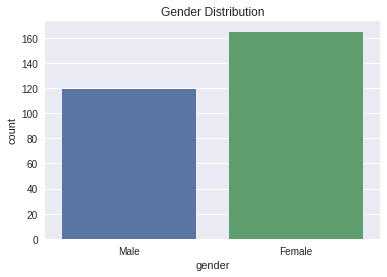

In [ ]:
sns.countplot(data['gender']).set_title("Gender Distribution")
plt.show()

- The highest gender observation is **Female**

In [ ]:
data['dessert'].unique()

array(['Maybe', 'Yes', 'No'], dtype=object)

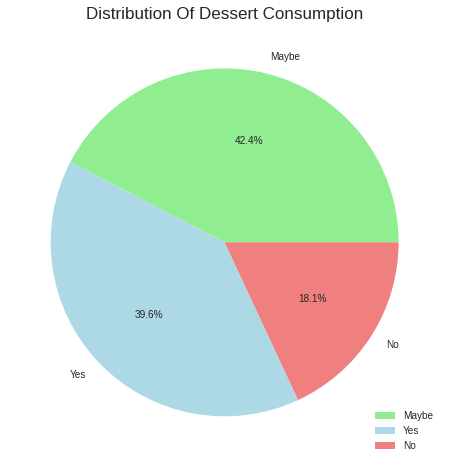

In [ ]:
plt.figure(figsize = (8, 8))
plt.pie(data['dessert'].value_counts(), colors = ['lightgreen', 'lightblue','lightcoral'], 
        labels = ['Maybe', 'Yes','No'], autopct = '%.1f%%')
plt.title('Distribution Of Dessert Consumption', fontsize = 17)
plt.axis('off')
plt.legend()
plt.show()

- We can conclude that most of the people consume desserts

In [ ]:
print(f"The total number of observation recorded is {data['participant_id'].nunique()}")

The total number of observation recorded is 288


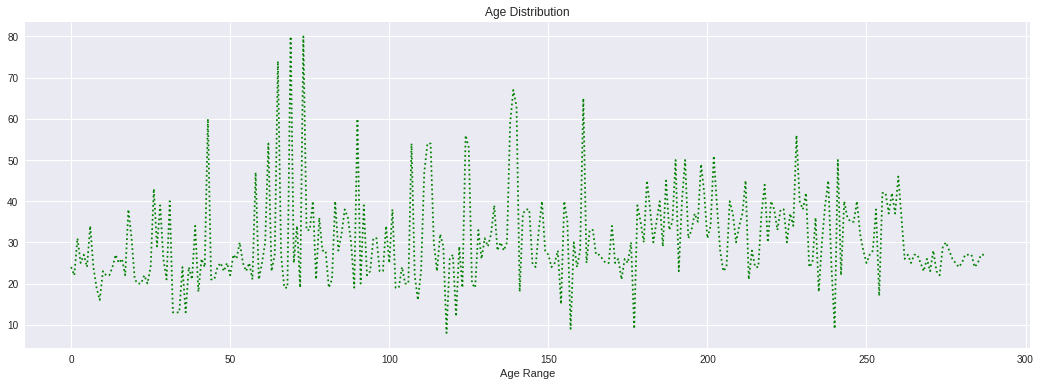

In [ ]:
plt.figure(figsize = (18, 6))
plt.plot(data['age'], linestyle = ':', color = 'green')
plt.title("Age Trend")
plt.xlabel("Age Range")
plt.show()

- Highest trend occurs between 50 and 100

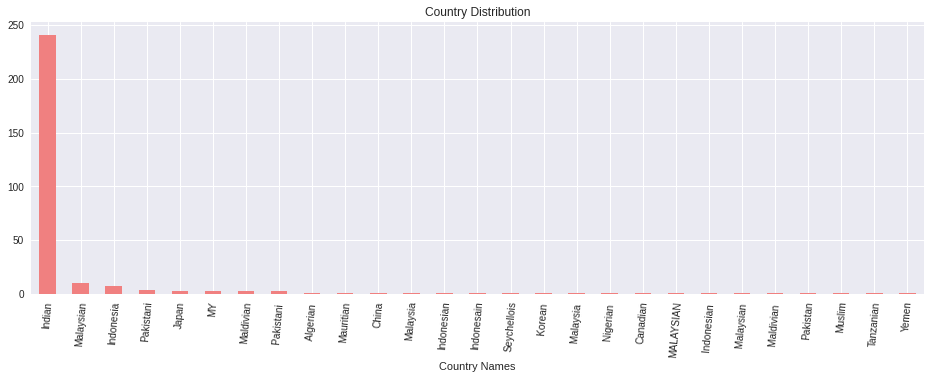

In [ ]:
plt.figure(figsize = (16, 5))
data['nationality'].value_counts().plot(kind = 'bar', title = 'Country Distribution', color = 'lightcoral')
plt.xticks(rotation = 85)
plt.xlabel('Country Names')
plt.show()

- The country with the highest distribution is **Indian**

In [ ]:
data['juice'].unique()

array(['Fresh Juice', 'Carbonated drinks'], dtype=object)

[]

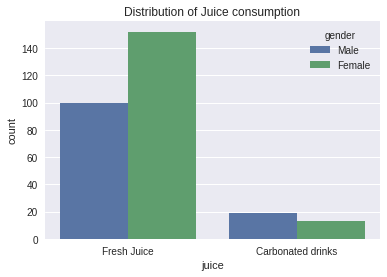

In [ ]:
sns.countplot(data['juice'], hue = data['gender']).set_title('Distribution of Juice consumption')
plt.plot()

- The most common juice is the **Fresh Juice**
- Female consume more Fresh juice than Male
- Male consume more Carbonated Drinks than Female

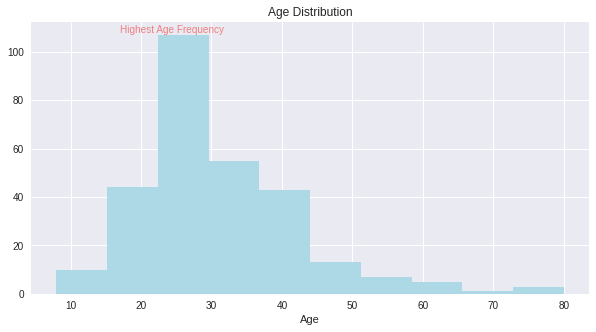

In [ ]:
plt.figure(figsize = (10, 5))
plt.text(17, 108, 'Highest Age Frequency', color = 'lightcoral')
plt.hist(data['age'], color = 'lightblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.show()

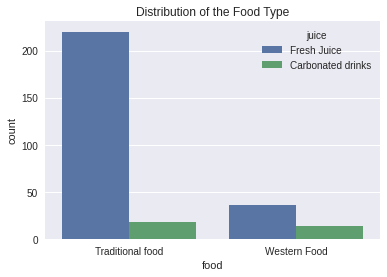

In [ ]:
sns.countplot(data['food'], hue = data['juice']).set_title('Distribution of the Food Type')
plt.show()

- Most of the people consume **Traditional Food**
- Most of the people that take Fresh Juice takes **Traditional Food** than **Western Food**

[]

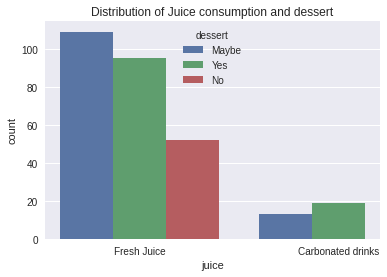

In [ ]:
sns.countplot(data['juice'], hue = data['dessert']).set_title('Distribution of Juice consumption and dessert')
plt.plot()

- Those who consume Fresh Juice will likely consume dessert

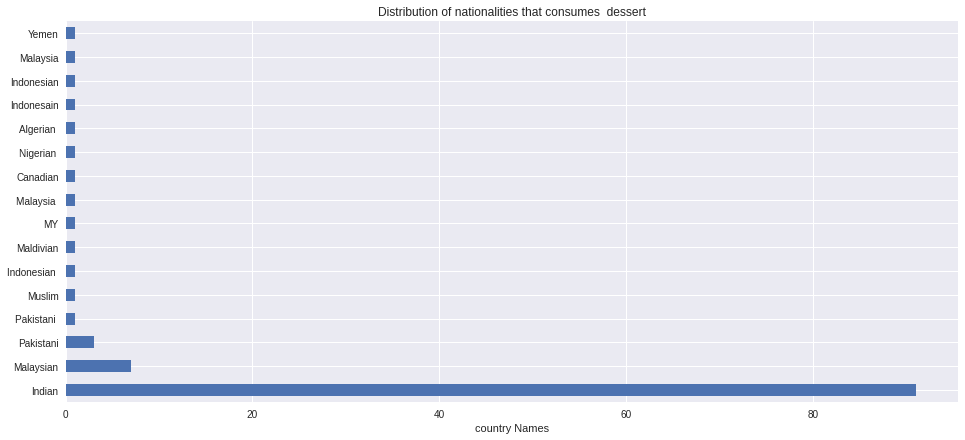

In [ ]:
# nationalities that consume more dessert
plt.figure(figsize = (16, 7))
data[data['dessert'] == 'Yes']['nationality'].value_counts().plot(kind = 'barh', title = 'Distribution of nationalities that consumes  dessert')
# plt.xticks(rotation = 85)
plt.xlabel('country Names')
plt.show()

- Indians consume more dessert

### Data Preparation

In [ ]:
#Checking for missing values in the dataset
data.isnull().sum()

timestamp         0
participant_id    0
gender            4
nationality       0
age               0
food              0
juice             0
dessert           0
dtype: int64

- The Gender column has some missing values

In [ ]:
# most common value in the gender column
data['gender'].mode()

0    Female
dtype: object

In [4]:
# Replacing the missing values with the mode
data['gender'] = data['gender'].fillna('Female')

In [5]:
# Extracting new features from timestamp column
data['timestamp'] = data['timestamp'].apply(lambda s: str(s)[0:10])
data['timestamp'] = pd.to_datetime(data['timestamp'], format = '%Y-%m-%d')
data['year'] = data['timestamp'].dt.year
data['month'] = data['timestamp'].dt.month_name()
data['day'] = data['timestamp'].dt.day_name()

data = data.drop('timestamp', axis = 1) #dropping the redundant timestamp columns
data.head()

,participant_id,gender,nationality,age,food,juice,dessert,year,month,day
0,FPS001,Male,Indian,24,Traditional food,Fresh Juice,Maybe,2019,May,Tuesday
1,FPS002,Female,Indian,22,Western Food,Carbonated drinks,Yes,2019,May,Tuesday
2,FPS003,Male,Indian,31,Western Food,Fresh Juice,Maybe,2019,May,Tuesday
3,FPS004,Female,Indian,25,Traditional food,Fresh Juice,Maybe,2019,May,Tuesday
4,FPS005,Male,Indian,27,Traditional food,Fresh Juice,Maybe,2019,May,Tuesday


In [ ]:
data['year'].unique()

array([2019])

- All observations were recorded in the year **2019**, Hence the year column will be dropped.

In [ ]:
data['month'].unique()

array(['May'], dtype=object)

- All observations were recorded in the month **May**, Hence the month column will be dropped.

In [6]:
data = data.drop(['month', 'year'], axis = 1)

In [ ]:
data['day'].unique()

array(['Tuesday', 'Wednesday', 'Thursday', 'Friday'], dtype=object)

#### Further Analysis

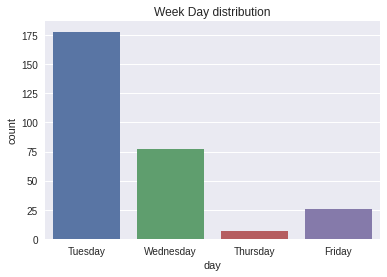

In [ ]:
sns.countplot(data['day']).set_title('Week Day distribution')
plt.show()

- Tuesday has the highest frequency

### Further Data Preparation

In [13]:
# Let us define the predictor columns and the target column 
# X is the predictor
# y is the target variable
x = data.drop(['food', 'participant_id'], axis = 1)
y = data['food']

In [15]:
x.head()

,gender,nationality,age,juice,dessert,day
0,Male,Indian,24,Fresh Juice,Maybe,Tuesday
1,Female,Indian,22,Carbonated drinks,Yes,Tuesday
2,Male,Indian,31,Fresh Juice,Maybe,Tuesday
3,Female,Indian,25,Fresh Juice,Maybe,Tuesday
4,Male,Indian,27,Fresh Juice,Maybe,Tuesday


In [20]:
ord = OrdinalEncoder() #instantiate the encoder

x.iloc[:, [0, 1, 3, 4, 5]] = ord.fit_transform(x.iloc[:, [0, 1, 3, 4, 5]]) #selected the column to encode and then fitted the encoder

In [21]:
x.head()  #To check if the values were successfully encoded

,gender,nationality,age,juice,dessert,day
0,1.0,3.0,24,1.0,0.0,2.0
1,0.0,3.0,22,0.0,2.0,2.0
2,1.0,3.0,31,1.0,0.0,2.0
3,0.0,3.0,25,1.0,0.0,2.0
4,1.0,3.0,27,1.0,0.0,2.0


In [ ]:
#Encoding the values of y using map
y = y.to_frame() # convert y to a dataframe
food_map = {'Traditional food': 1, 'Western Food': 0}
y['food'] = y['food'].map(food_map)
y = y.squeeze() # Return y back to series

In [34]:
# Splitting the dataset into train and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = y) 

In [35]:
#Modelling with random forest algorithm
rf = RandomForestClassifier()
rf.fit(x_train.values, y_train)

RandomForestClassifier()

In [37]:
#Writing a function to evaluate the performance of the models
def evaluate(model):
  y_pred = model.predict(x_test)
  print(f"The accuracy score of the {type(model).__name__} is {round(accuracy_score(y_test, y_pred) * 100)}%\n")
  # print(f"The F1 score of the {type(model).__name__} is {round(f1_score(y_test, y_pred, average='macro') * 100)}%\n\n")
  plot_confusion_matrix(model, x_test, y_test)
  plt.xlabel("Predicted Label")
  plt.title("Confusion Matrix")
  plt.show()

The accuracy score of the RandomForestClassifier is 76%



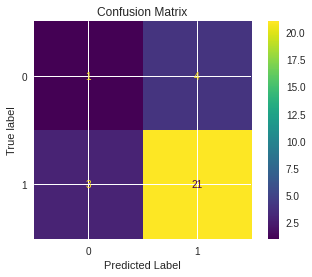

In [38]:
evaluate(rf)

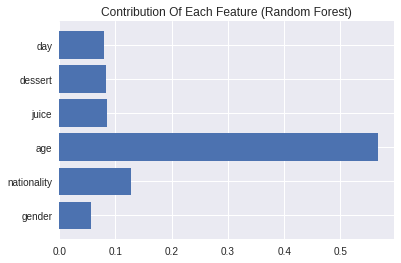

In [39]:
plt.barh(x.columns, rf.feature_importances_)
plt.title("Contribution Of Each Feature (Random Forest)")
plt.show()